In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


## This notebook implement DDPM, the fundamental component of Stable Diffusion
Denoising Diffusion Probabilistic Models (DDPM) using diffusion process by adding noise and try to reverse the diffusion process. By reversing the diffusion process, it can generate the original input from a random noise.
[paper](https://arxiv.org/abs/2006.11239)

You can checkout the explaination for the math of DDPM [here](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

#### Importing library

In [ ]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

#### Config 

In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [ ]:
no_train = False
fashion = True
batch_size = 128
n_epochs = 20
lr = 0.0001
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

#### Utility functions

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [ ]:
# Shows the first batch of images
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

#### Transform the input

In [ ]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)
    ]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 14058514.11it/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211301.66it/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3874243.01it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20067171.93it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



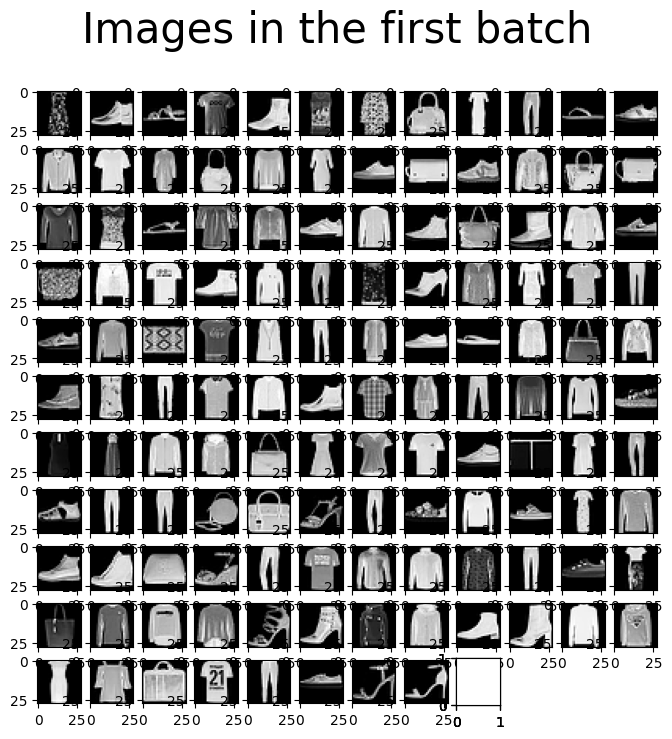

In [ ]:
show_first_batch(loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Diffusion Models

#### Forward process
Forward process (diffusion process) is the process of adding noise to the original input according to a variance schedule $\beta_1, \beta_2,...,\beta_T $

$$
q(x_{1:T}|x_0) := \prod_{t=1}^{T}q(x_t|x_{t-1})
$$
$$
q(x_t|x_{t-1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1},\beta\textbf{I})
$$

#### Reverse process
Starting at $p(x_T) = \mathcal{N}(x_T,\textbf{0}, \textbf{I})$, it will try to reach the $p(x_0)$
$$
p_{\theta}(x_{0:T}) := p(x_T)\prod_{t=1}^{T} p_{\theta}(x_{t-1}|x_t)
$$
$$
p_{\theta}(x_{t-1}|x_t) := \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t),\Sigma_{\theta}(x_t,t))
$$


Let $\alpha_t := 1-\beta_t$ and $\bar{\alpha}_t = \Pi_{s=1}^{t}\alpha_s$, we are able to get the diffusion process of any given $t$ using

$$
q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{a}_t}x_0, (1-\bar{a})\textbf{I})
$$
$$
\mu_{\theta} = \frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}}\epsilon_{\theta})
$$

In [ ]:
class DDPM(nn.Module):
  def __init__(self, network, n_steps=200, min_b=10**-4, max_b= 0.02,device=None, image_chw=(1,28,28)):
    super().__init__()
    self.n_steps = n_steps
    self.device = device
    self.image_chw = image_chw
    self.network = network.to(device)
    self.beta = torch.linspace(min_b,max_b,n_steps).to(device)
    self.alpha= 1 - self.beta
    self.alpha_bar=torch.tensor([torch.prod(self.alpha[:i+1]) for i in range(len(self.alpha))]).to(device)

  def forward(self,x0,t,eta=None): # forward process on DDPM
    n,c,h,w = x0.shape
    a_bar = self.alpha_bar[t]
    if eta is None:
      eta = torch.randn(n,c,h,w).to(self.device)

    noise = a_bar.sqrt().reshape(n,1,1,1)*x0 + (1-a_bar).sqrt().reshape(n,1,1,1)*eta
    return noise

  def backward(self,x,t): # reverse process on DDPM
    return self.network(x,t)


In [ ]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

### Reverse process
Guessing $q(x_{t-1}| x_t)$ is a difficult task. The formula can be changed to $q(x_{t-1}|x_t,x_0)$, which make the reverse condition trackable.
$$
q(x_{t-1}|x_t,x_0) := \mathcal{N}(x_{t-1}; \tilde{\mu}(x_t,x_0),\tilde{\beta}\textbf{I})
$$
Using Bayes' rule
$$
q(x_{t-1}|x_t,x_0) = \frac{q(x_{t-1}|x_0)}{q(x_t|x_0)}
$$ 
Which can be translated to
$$
    something * exp( -\frac{1}{2}(\frac{(x_t-\sqrt{a_t}x_{t-1})^2}{\beta_t} + \frac{(x_{t-1}-\sqrt{a_{t-1}}x_0)^2}{1-\bar{a}_{t-1}} + \frac{(x_t-\sqrt{a_t}x_0)^2}{x_t} ))
$$
$$
    = something * exp( -\frac{1}{2}((\frac{\alpha_t}{\beta_t} + \frac{1}{1-\bar{a}_{t-1}})x_{t-1}^2 - (\frac{2\sqrt{a_t}}{\beta_t} + \frac{2\sqrt{\bar{a}_{t-1}}}{1-\bar{a}_{t-1}})x_{t-1} + C(x_t,x_0) ))
$$
where $C(x_t,x_0)$ is a function not related to $x_{t-1}$

You can see the pattern of Normal Distribution here. Friendly reminder, with normal distribution, $f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$
Therefore:

$$
\tilde{\beta}_t = 1/(\frac{\alpha_t}{\beta_t} + \frac{1}{1-\bar{a}_{t-1}}) = \frac{1-\bar{a}_{t-1}}{1-\bar{a}_t}\beta_t
$$

$$
\tilde{\mu}(x_t,x_0) = (\frac{\sqrt{a_t}}{\beta_t} + \frac{\sqrt{\bar{a}_{t-1}}}{1-\bar{a}_{t-1}})/(\frac{\alpha_t}{\beta_t} + \frac{1}{1-\bar{a}_{t-1}}) = \frac{\sqrt{a_t}(1-\bar{a}_{t-1})}{1-\bar{a}_t}x_t+ \frac{\sqrt{\bar{a}_{}t-1}\beta_t}{1-\bar{a}_t}x_0
$$

Replacing $x_0$ by the forward process, we have
$$
\tilde{u}_t = \frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}}\epsilon_t)
$$

### So far we have
$$
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}};\epsilon_{\theta}(x_t,t)),\Sigma_{\theta}(x_t,t))
$$

$$
q(x_{t-1}|x_t,x_0) = \mathcal{N}(x_{t-1};\frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}}\epsilon_t);\frac{1-\bar{a}_{t-1}}{1-\bar{a}_t}\beta_t)
$$

### Loss function
The loss function of DDPM is similar to VAEs, so we can use variantional lower bound.
$$-logp_\theta(x_0) \le -logp_\theta(x_0) + D_{KL}(q(x_{1:T}|x_0)||p_\theta(x_{1:T}|x_0)) $$
Which leads to
$$
L_{VLB} = \Epsilon_{q(x_{0:T})}[log\frac{q(x_{1:T}|x_0)}{p_\theta(x_{0:T}|x_0)}]

$$
$$
L_{VLB} = \Epsilon_{q}[D_{KL}(q(x_{T}|x_0)|p_\theta(x_T)) + \sum^{T}_{t=2}D_{KL}(q(x_{t-1}|x_t)||p_\theta(x_{t-1}|x_t)) - logp_\theta(x_0|x_1)]
$$

Label:

* $L_T = D_{KL}(q(x_{T}|x_0)|p_\theta(x_T))$

* $L_t = D_{KL}(q(x_{t-1}|x_t)||p_\theta(x_{t-1}|x_t))$ for $1\le t \le T-1$

* $L_0 = logp_\theta(x_0|x_1)$

$L_T$ is a constant, $L_0$ is using a separate discrete decoder from $\mathcal{N}(x_{t-1}; \mu_{\theta}(x_1,1),\Sigma_{\theta}(x_1,1))$, so we only have to train $L_t$

In [ ]:
class Block(nn.Module):
  def __init__(self,shape, in_c, out_c, kernel_size=3, stride=1,padding=1, activation=None, normalize= True):
    super().__init__()
    self.ln= nn.LayerNorm(shape)
    self.conv1 = nn.Conv2d(in_c,out_c,kernel_size,stride,padding)
    self.conv2 = nn.Conv2d(out_c,out_c,kernel_size,stride,padding)
    self.activation = nn.SiLU() if activation is None else activation
    self.normalize = normalize

  def forward(self,x):
    out = self.ln(x) if self.normalize else x
    out = self.activation(self.conv1(out))
    out = self.activation(self.conv2(out))
    return out

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_steps=1000, time_emb_dim=100):
    super().__init__()
    self.time_embed = nn.Embedding(n_steps, time_emb_dim)
    self.time_embed.weight.data = self.sinusoidal_embedding(n_steps,time_emb_dim)
    self.time_embed.requires_grad_(False)

    # Left U
    self.te1 = self._make_te(time_emb_dim, 1)
    self.b1 = nn.Sequential(
        Block((1, 28, 28), 1, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10)
    )
    self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

    self.te2 = self._make_te(time_emb_dim, 10)
    self.b2 = nn.Sequential(
        Block((10, 14, 14), 10, 20),
        Block((20, 14, 14), 20, 20),
        Block((20, 14, 14), 20, 20)
    )
    self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
    self.te3 = self._make_te(time_emb_dim, 20)
    self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
    self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

    # Middle U

    self.te_mid = self._make_te(time_emb_dim, 40)
    self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

    # Second half
    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(40, 40, 4, 2, 1),
        nn.SiLU(),
        nn.ConvTranspose2d(40, 40, 2, 1)
    )

    self.te4 = self._make_te(time_emb_dim, 80)
    self.b4 = nn.Sequential(
        Block((80, 7, 7), 80, 40),
        Block((40, 7, 7), 40, 20),
        Block((20, 7, 7), 20, 20)
    )

    self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
    self.te5 = self._make_te(time_emb_dim, 40)
    self.b5 = nn.Sequential(
        Block((40, 14, 14), 40, 20),
        Block((20, 14, 14), 20, 10),
        Block((10, 14, 14), 10, 10)
    )

    self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
    self.te_out = self._make_te(time_emb_dim, 20)
    self.b_out = nn.Sequential(
        Block((20, 28, 28), 20, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10, normalize=False)
    )

    self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

  def forward(self, x, t):
    t = self.time_embed(t)
    n = len(x)
    out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))
    out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))
    out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

    out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

    out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
    out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

    out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
    out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

    out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
    out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

    out = self.conv_out(out)

    return out

  @staticmethod
  def sinusoidal_embedding(n,d):

    embedding = torch.zeros(n,d)
    wk = torch.tensor([1/10000 ** (2*j/d) for j in range(d)])
    wk = wk.reshape((1,d))

    t = torch.arange(n).reshape((n,1))
    embedding[:,::2]  = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

  def _make_te(self, dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out)
    )

In [ ]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = DDPM(UNet(n_steps), n_steps=n_steps, min_b=min_beta, max_b=max_beta, device=device)

In [ ]:
from numpy.random import beta
def sampling(ddpm, n_sample=16,device=None, c=1, h=28, w=28):

  with torch.no_grad():
    if device is None:
      device = ddpm.device
    x = torch.randn(n_sample,c,h,w).to(device)

    for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
      time_tensor = (torch.ones(n_sample,1)*t).to(device).long()
      eta_theta = ddpm.backward(x, time_tensor)

      alpha_t = ddpm.alpha[t]
      alpha_t_bar = ddpm.alpha_bar[t]

      x = 1/alpha_t.sqrt() * (x - (1 - alpha_t)/(1-alpha_t_bar).sqrt()*eta_theta)

      if t>0:
        z = torch.randn(n_sample, c,h,w).to(device)

        beta_t = ddpm.beta[t]
        prev_alpha_t_bar = ddpm.alpha_bar[t-1] if t >0 else ddpm.alpha[0]
        beta_tilda_t = ((1-prev_alpha_t_bar)/(1-alpha_t_bar))* beta_t
        sigma_t = beta_tilda_t.sqrt()

        x = x + sigma_t*z

  return x

In [ ]:
show_forward(ddpm, loader, device)

In [ ]:
def training_loop(ddpm, loader, optim, device, n_epochs=20, display=False, store_path="ddpm_model.pt"):
  mse = nn.MSELoss()
  best_loss = float("inf")
  n_steps = ddpm.n_steps
  for epoch in tqdm(range(n_epochs), desc=f"Training process", colour="#00ff00"):
    epoch_loss = 0.0
    ddpm.network.train()
    for step, batch in enumerate(tqdm(loader, leave=False,desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
      x0 = batch[0].to(device)
      n = len(x0)

      # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
      eta = torch.randn_like(x0).to(device)
      t = torch.randint(0, n_steps, (n,)).to(device)

      noisy_imgs = ddpm(x0, t, eta)
      eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

      loss = mse(eta_theta,eta)
      optim.zero_grad()
      loss.backward()
      optim.step()

      epoch_loss += loss.item() * len(x0)/len(loader.dataset)
    if display:
      show_images(sampling(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(ddpm.state_dict(), store_path)
        log_string += " --> Best model ever (stored)"

    print(log_string)


Training process:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

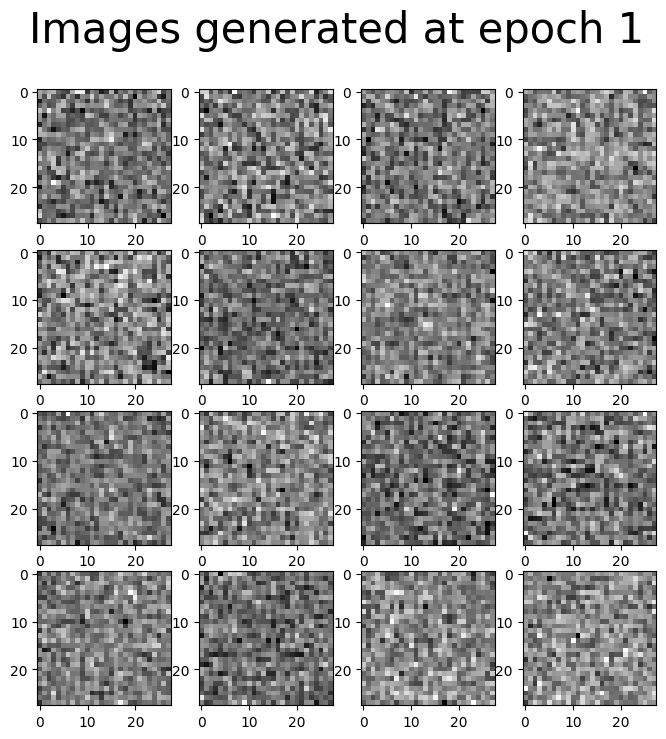

Loss at epoch 1: 0.932 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

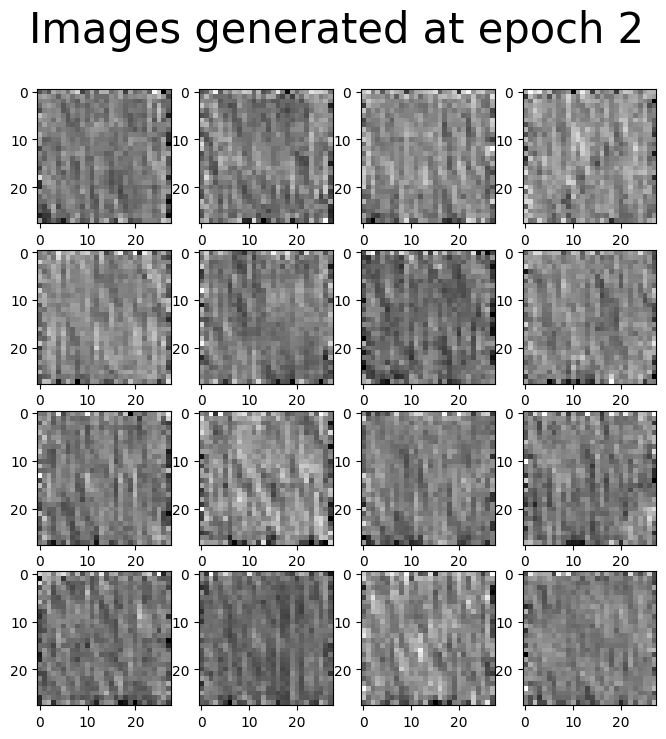

Loss at epoch 2: 0.587 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

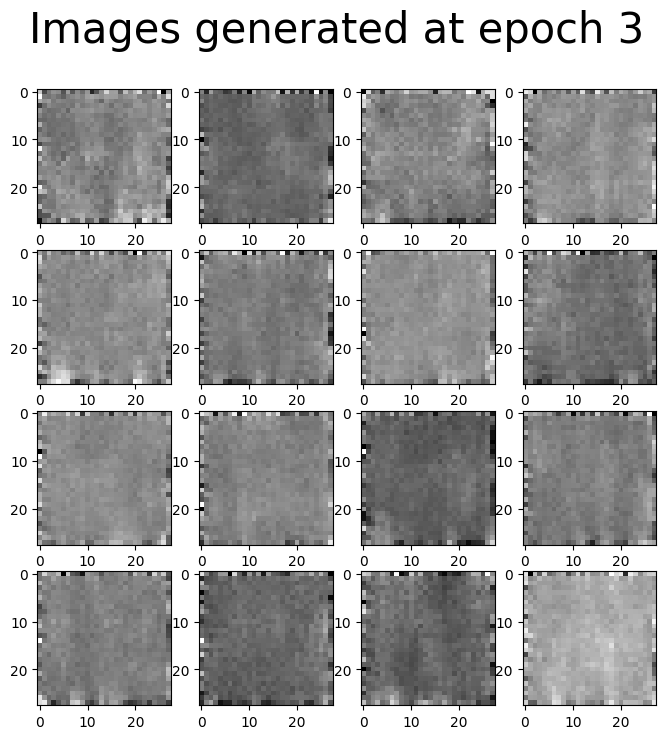

Loss at epoch 3: 0.275 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

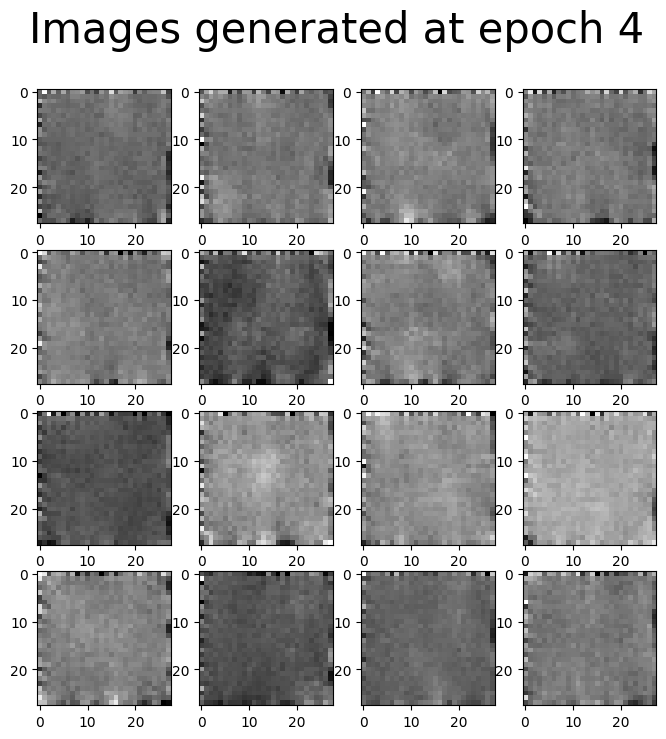

Loss at epoch 4: 0.214 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

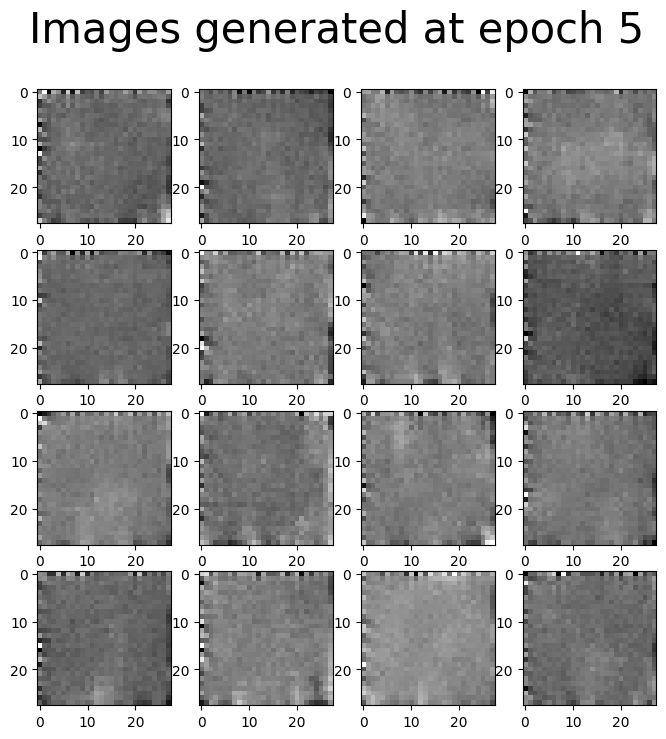

Loss at epoch 5: 0.192 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

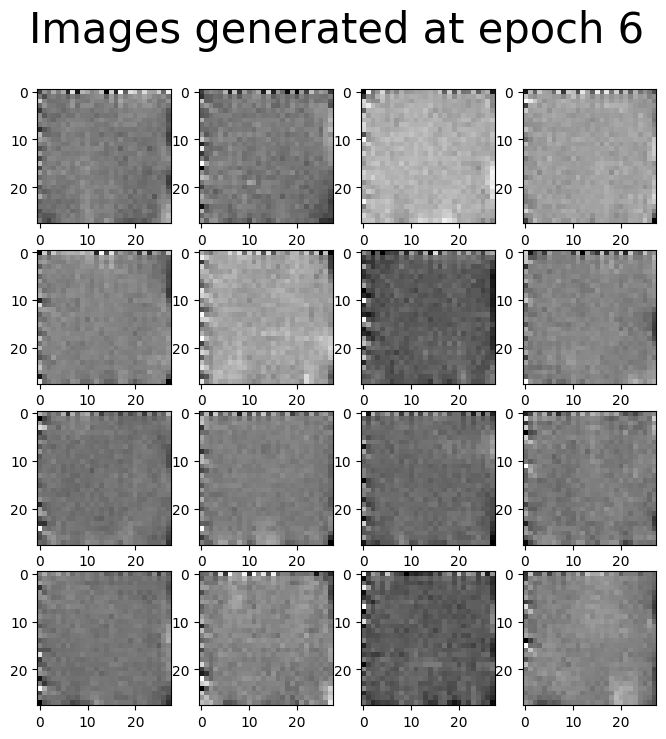

Loss at epoch 6: 0.173 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

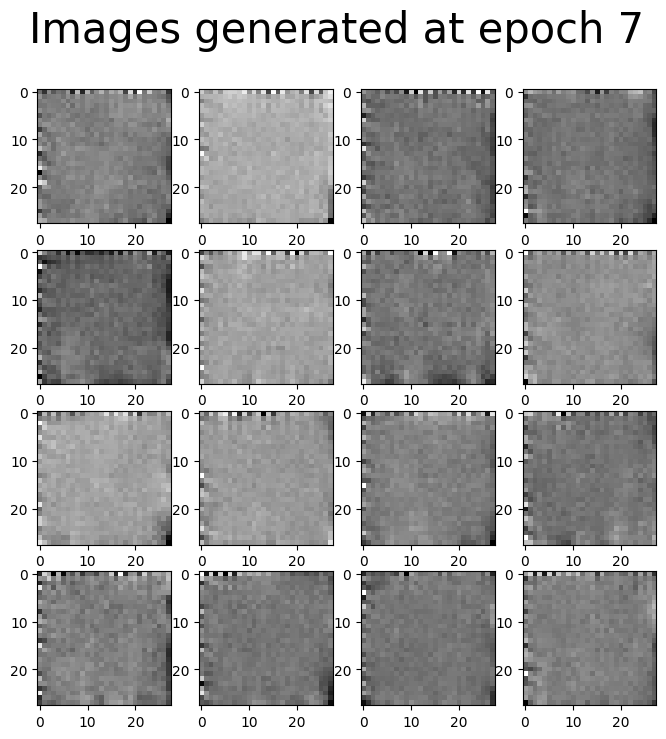

Loss at epoch 7: 0.160 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

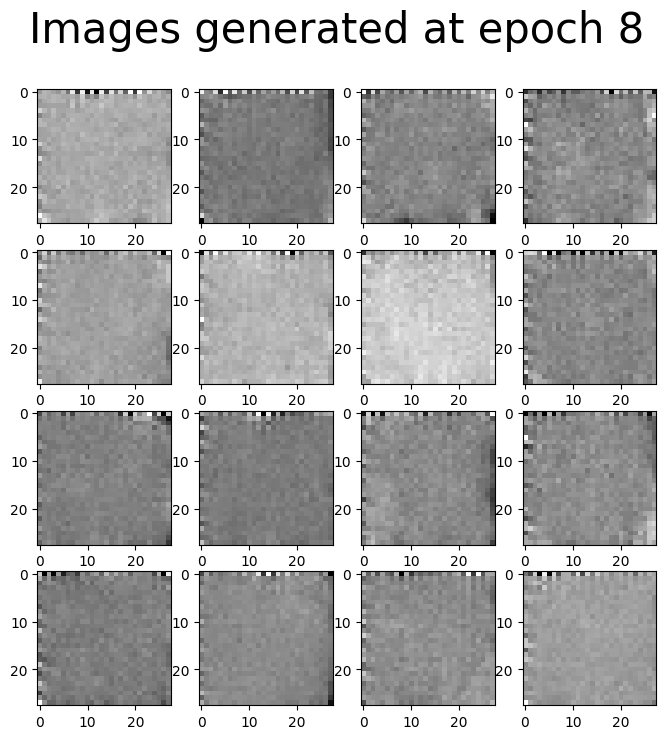

Loss at epoch 8: 0.147 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

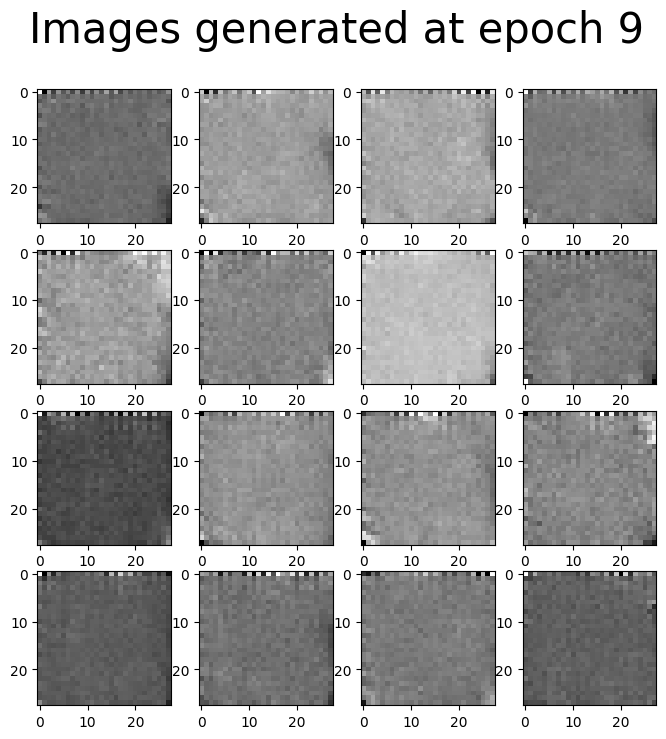

Loss at epoch 9: 0.136 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

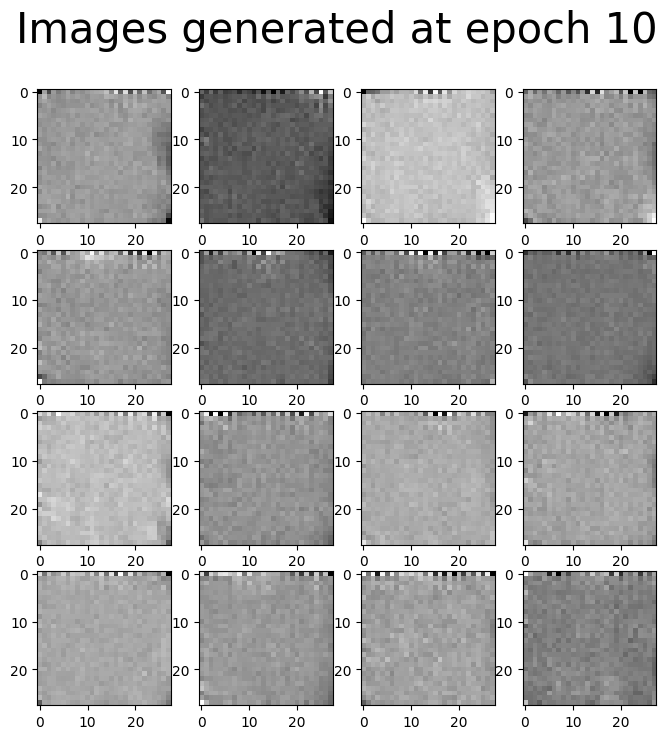

Loss at epoch 10: 0.129 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

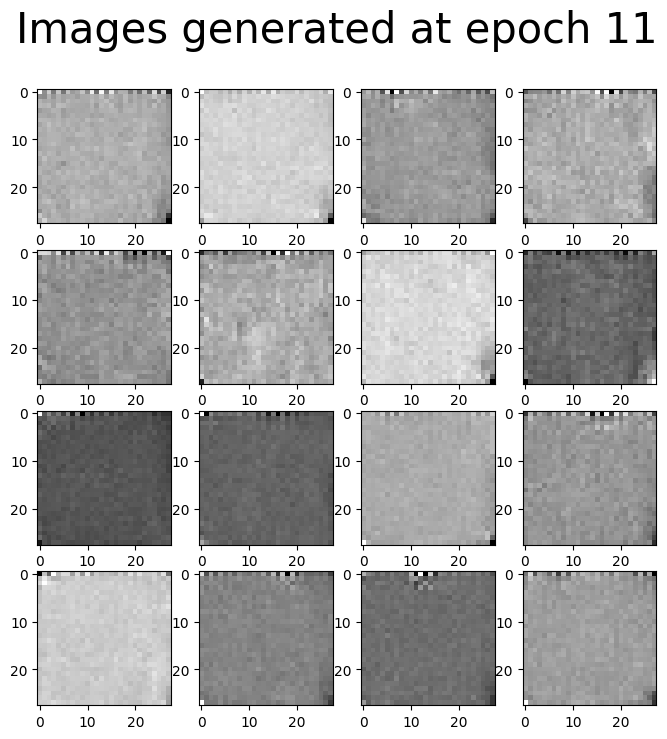

Loss at epoch 11: 0.119 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

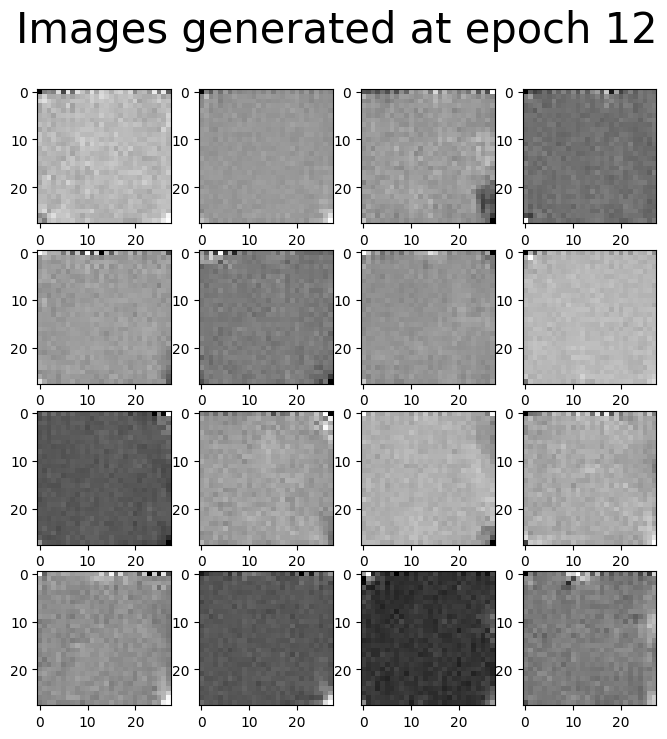

Loss at epoch 12: 0.114 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

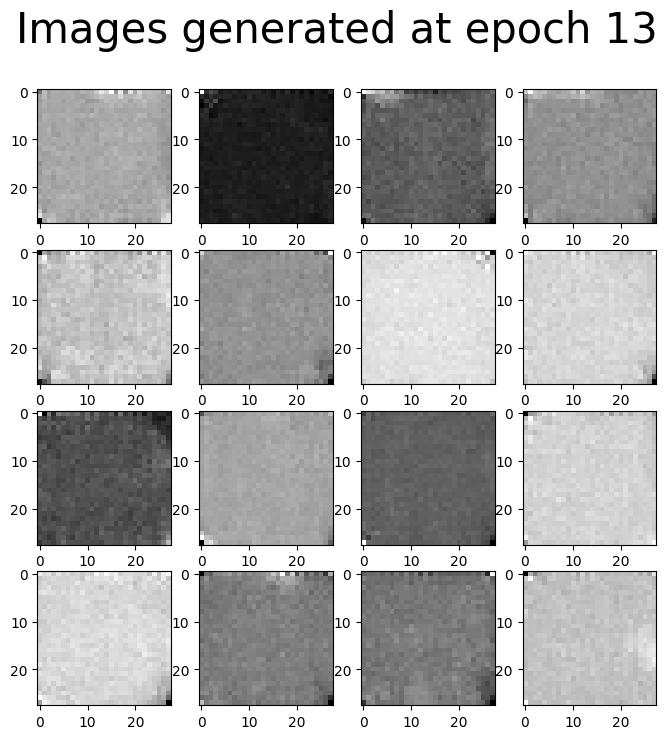

Loss at epoch 13: 0.109 --> Best model ever (stored)


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

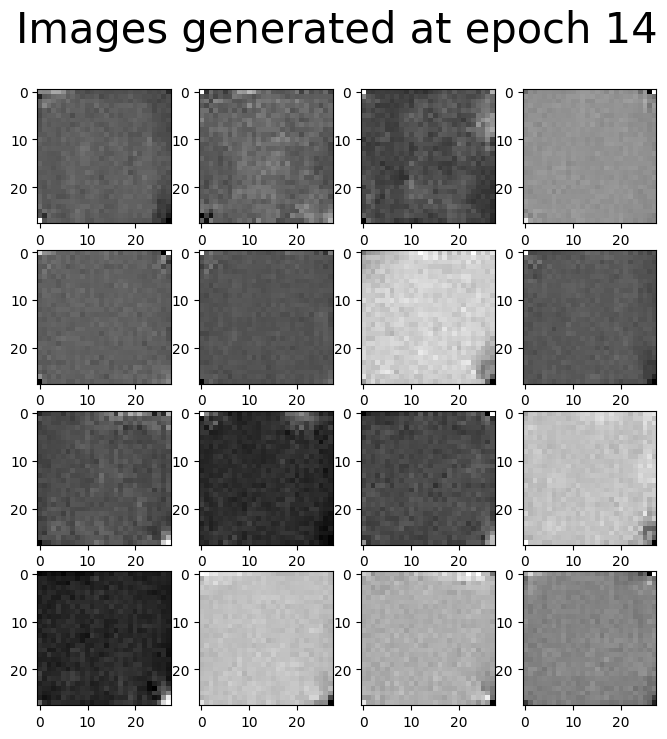

Loss at epoch 14: 0.105 --> Best model ever (stored)


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

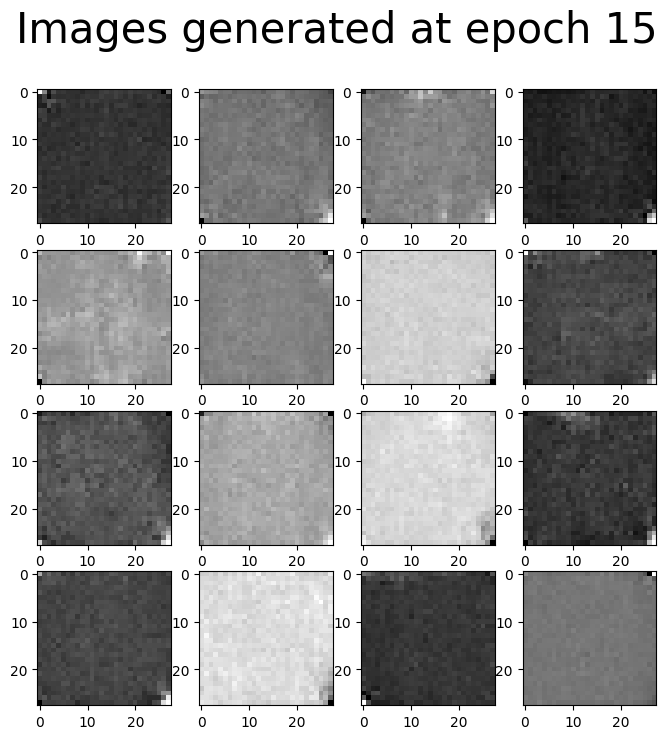

Loss at epoch 15: 0.100 --> Best model ever (stored)


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

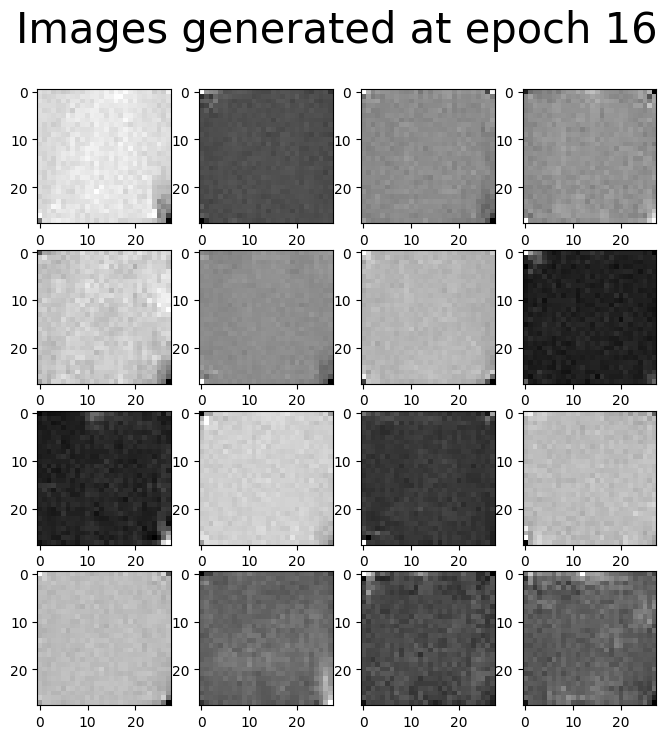

Loss at epoch 16: 0.098 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

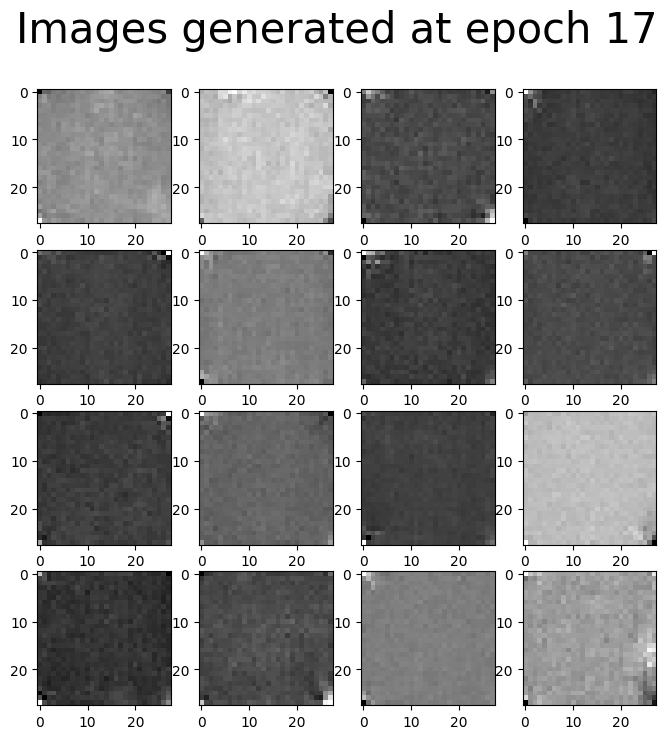

Loss at epoch 17: 0.095 --> Best model ever (stored)


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

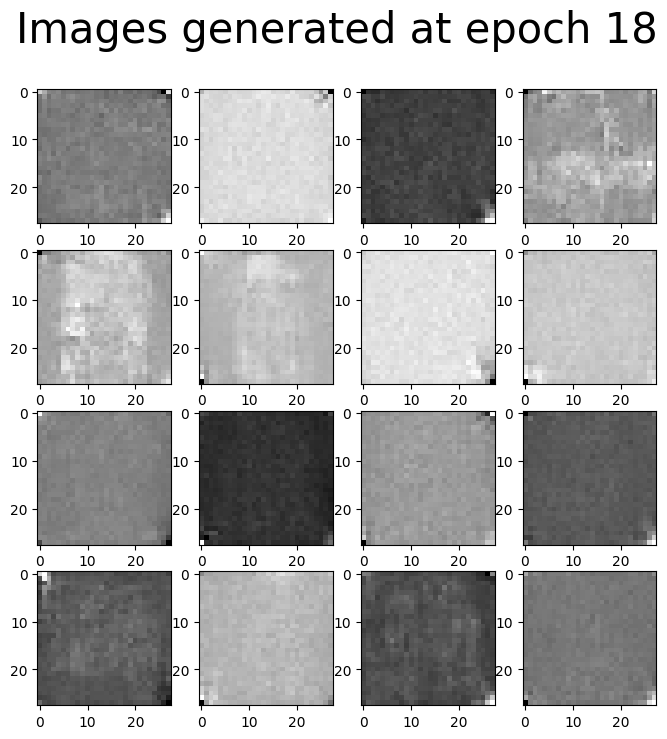

Loss at epoch 18: 0.094 --> Best model ever (stored)


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

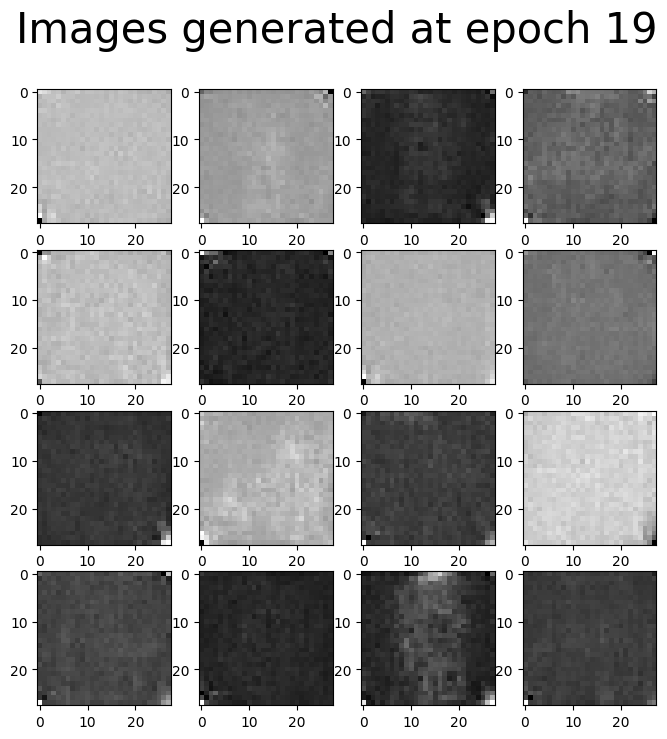

Loss at epoch 19: 0.092 --> Best model ever (stored)


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

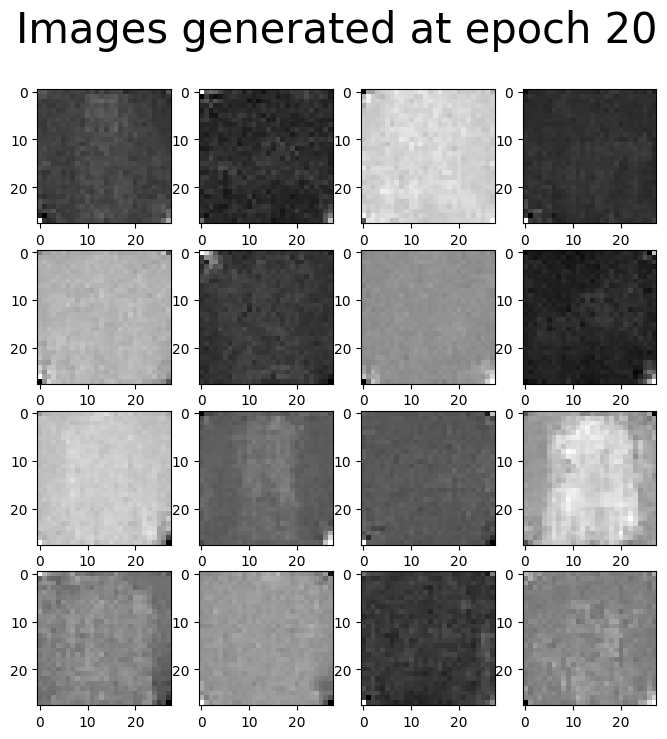

Loss at epoch 20: 0.090 --> Best model ever (stored)


In [ ]:
optim=AdamW(ddpm.parameters(),lr=2e-5,eps=1e-8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_loop(ddpm, loader,optim, device, n_epochs=20,  display=True)